# Рынок заведений общественного питания Москвы

**Описание проекта:**
Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.
***
**Источник данных: Открытые данные о заведениях общественного питания в Москве**

**Описание данных:**
Таблица rest_data**
***
object_name — название объекта общественного питания;
chain — сетевой ресторан;
object_type — тип объекта общественного питания;
address — адрес;
number — количество посадочных мест.

<a id="Содержание"></a>
## Cодержание:
**1. [Шаг №1. Загрузка данных и подготовка к анализу](#step-1)**\
**2. [Шаг №2. Анализ данных](#step-2)**\
   2.1. [Cоотношение сетевых и несетевых заведений по количеству](#21)\
   2.2. [Cоотношение количества объектов общественного питания по видам](#22)\
   2.3. [Для какого вида объекта общественного питания характерно сетевое распространение?](#23)\
   2.4. [Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?](#24)\
   2.5. [Среднее количество посадочных мест для каждого вида объекта общественного питания.](#25)\
   2.6. [График топ-10 улиц по количеству объектов общественного питания. Популярные районы Москвы.](#26)\
   2.7. [Число улиц с одним объектом общественного питания. В каких районах Москвы находятся эти улицы?](#27)\
   2.8. [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.](#28)\
**[Общий вывод](#summary)\
[Презентация](#presentation)**


In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

# импорт библиотек для парсинга
import requests
import json 

# настройка конвертации дат для графиков
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# настройка окружения
pd.options.display.max_columns=None
pd.options.display.float_format='{: .2f}'.format
sns.set(style="whitegrid")
plt.style.use('seaborn-pastel')
#plt.style.available

<a id="step-1"></a>
## Шаг №1. Загрузка данных и их подготовка к анализу [▲](#Содержание)   

In [3]:
df_catering = pd.read_csv('/datasets/rest_data.csv')

In [4]:
display(df_catering.info())
df_catering.head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


None

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10


**Вывод:** Потенциальные проблемы (кроме пропусков, дубликатов) могут быть в столбцах с наименованиями 'object_name' (варианты написания одного и того же)  и 'number' - нулевые значения. 

**Проверка пропусков и дубликатов**

In [5]:
# наличие дубликатов 
print('Число полных дубликатов данных в таблице:',
      df_catering.shape[0] - df_catering.drop_duplicates().shape[0])

Число полных дубликатов данных в таблице: 0


In [6]:
# проверка пропусков
df_catering.isna().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

**Проверка числа посадочных мест в 'number' на нулевые значения**

In [7]:
# тест на наличие нулевых значений в столбце с количеством мест
df_catering[df_catering['number'] == 0].shape

(1621, 6)

**Вывод:** имеем 1621 поле с нулевым числом мест, в дальнейших расчетах это может сильно исказить значения среднего и медианы, поэтому заменяем найденные значения на Nan. Это позволит избежать искажений в соответствующих расчетах.

In [8]:
# замена 0 на nan в поле 'number' - число посадочных мест
df_catering['number'].replace(0, np.nan, inplace=True) 

**Проверка наименований в 'object_name'**

В названии объектов не весь текст является собственно названием. В некоторых записях дублируется тип заведения, например 'Кафе «Вишневая метель»'. Это мужет привести к ошибкам в группировке по названиям, когда потребуется оценить сетевые компании. В данных могут присутствовать несколько вариаций написания одного и того же названия. 

In [10]:
# отбор самых 'популярных' названий
# группируем по названию и принадлежности к сети
object_name = df_catering.groupby(['object_name', 'chain'])['id'].count().reset_index().sort_values(by='id', ascending=False)
object_name.columns = ['object_name', 'chain', 'object_name_count']

In [11]:
# вывод ТОП-7 названий 
#object_name[object_name['chain']=='да'].head()
object_name.head(7)

,object_name,chain,object_name_count
8450,Столовая,нет,267
3920,Кафе,нет,236
10048,Шаурма,нет,234
644,KFC,да,155
10234,Шоколадница,да,141
2100,Бургер Кинг,да,122
5811,Макдоналдс,да,122


У части данных вообще отсутствуют названия, произвольно указан только формат заведения. В границах поставленных в исследовании задач это несущественно, оставляем. Однако поскольку требуется оценить параметры сетевых точек, желательно чтобы названия сетевых компаний были корректными. Выявляем потенциальные проблемы в написании названия для одного из популярных брендов.

In [12]:
# проверим корретность названий по бренду 'Шоколадница'
print('Общее число точек содержащих в названии слово Шоколадница:',
      object_name[object_name['object_name'].str.contains('Шоколадница')==True]['object_name_count'].sum(), 'шт.')
object_name[object_name['object_name'].str.contains('Шоколадница')==True]

Общее число точек содержащих в названии слово Шоколадница: 169 шт.


,object_name,chain,object_name_count
10234,Шоколадница,да,141
4629,Кафе «Шоколадница»,да,14
5353,Кофейня «Шоколадница»,да,4
4630,Кафе «Шоколадница»,нет,2
5370,Кофейня Шоколадница,да,2
10238,Шоколадница Экспресс,нет,1
10235,Шоколадница,нет,1
10236,Шоколадница Кофе Хаус,да,1
10237,Шоколадница Кофемания,да,1
10375,кафе «Шоколадница»,да,1


Имеем "весь набор" проблем: вариации написания 'кафе', строчные -заглавные буквы и т.д. Задача осложняется также тем, что мы не знаем однозначно: что является частью названия, а что формата заведения; где оригинальное название бренда, а где его "подделка". Тем не менее, есть закономерность: **'правильное' название взято в кавычки**. В примере с 'Шоколадницей', несмотря на обилие ошибок, изьятие названий из ковычек сократит их долю до **2.3%**. Правильному разделению поможет признак вхождения в сеть'chain' (он тоже может содержать ошибки). 

In [13]:
# в столбце 'object_name' оставляем только ту часть названия, которая находится в кавычках
# если кавычек в названии нет, оно остается без изменений
# удаляем текст до и после символов «»
df_catering['object_name'] = df_catering['object_name'].str.replace('.*.«', '')
df_catering['object_name'] = df_catering['object_name'].str.replace('».*', '');

In [14]:
# проверка результата (все как планировалось)
#df_catering[df_catering['object_name'].str.contains('Шоколадница')==True]['object_name'].value_counts()
#df_catering.groupby(['object_name', 'chain'])['id'].count().reset_index().sort_values(by='id', ascending=False).head(7)

**Вывод: дубликатов и пропусков в исходной таблице не обнаружено, в преобразовании типа данных нет необходимости. В столбце с числом посадочных мест 'number' выявлено 1621 нулевое значение, проведена их замена на Nan, чтобы убрать искажения в расчетах среднего и т.п. Проведена корректировка названий в столбце 'object_name', в итоге изменилась расстановка и статистика по сетевым брендам (Макдоналдс обошел БургерКинг по размеру сети и т.п.)**

<a id="step-2"></a>
## Шаг №2. Анализ данных[▲](#Содержание)    

<a id="21"></a>
**2.1. Cоотношение сетевых и несетевых заведений по количеству**[▲](#Содержание)    

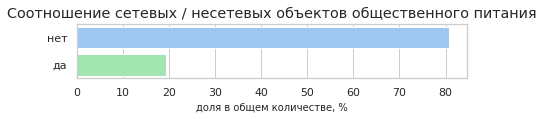

In [15]:
fig = plt.figure(figsize=(7, 1))
sns.barplot(data=(df_catering['chain'].value_counts(normalize=True)*100).reset_index(), y='index', x='chain', orient='h')
plt.title('Cоотношение сетевых / несетевых объектов общественного питания', fontdict={'fontsize': 'large'});
plt.xlabel('доля в общем количестве, %', fontdict={'fontsize': 'small'});
plt.ylabel('');

**Вывод:**  доля сетевых объектов общепита составляет 19% по количеству точек, остальных соответственно 81%.

<a id="22"></a>
**2.2. Cоотношение количества объектов общественного питания по видам**[▲](#Содержание)    

In [16]:
data_type = (df_catering['object_type'].value_counts(normalize=True)*100).reset_index()
#data_type = df_catering.groupby('object_type')['id'].count().reset_index()
data_type.rename(columns={'index':'object_type', 'object_type':'type_share'}, inplace=True)
data_type['type_share'] = np.round(data_type['type_share'], 2)

# для наглядности последующих графиков, сохраняем порядок видов объектов питания 
object_type_order = ['кафе', 'столовая', 'ресторан', 'предприятие быстрого обслуживания', 'бар', 'буфет', 'кафетерий',
             'закусочная','магазин (отдел кулинарии)']

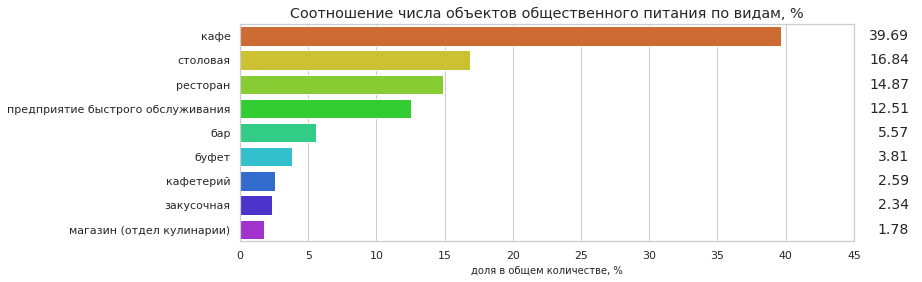

In [18]:
plt.figure(figsize=(11, 4))

sns.barplot(data=data_type, x='type_share', y='object_type', orient='h', palette='gist_rainbow', saturation =.6)
plt.title('Cоотношение числа объектов общественного питания по видам, %', fontdict={'fontsize': 'large'})
plt.xlabel('доля в общем количестве, %', fontdict={'fontsize': 'small'})
plt.ylabel('');
plt.xlim(0, 45);
the_table = plt.table(cellText=np.round(data_type[['type_share']], 2).values, 
                      bbox=(1, 0, 0.1, 1), edges='open')
the_table.auto_set_font_size(False)
the_table.set_fontsize(14);

**Вывод:** Наиболее рапространенный формат заведений - кафе (40%), затем идут столовые, рестораны и "фаст-фуд" с долей 12-17%. Остальные форматы занимают от 1,7% до 5.6% от общего количества.

<a id="23"></a>
**2.3. Для какого вида объекта общественного питания характерно сетевое распространение?**[▲](#Содержание)    

In [19]:
data_chain = df_catering.groupby(['object_type', 'chain'])['id'].count().reset_index()
data_chain['chain_share'] = data_chain.apply(
    lambda x: np.round
    (x['id'] / data_chain[data_chain['object_type'] == x['object_type']]['id'].sum() * 100, 2),
    axis=1)

In [20]:
# для наглядности, сохраняем порядок видов объектов питания как в предыдущем графике
# присоединяем столбец с долей сетевых заведений к таблице полученной в предыдущем пункте 'data_type'
data_type = data_type.merge(data_chain[data_chain['chain'] == 'да'][['object_type', 'chain_share']], 
                            on='object_type', how='left')

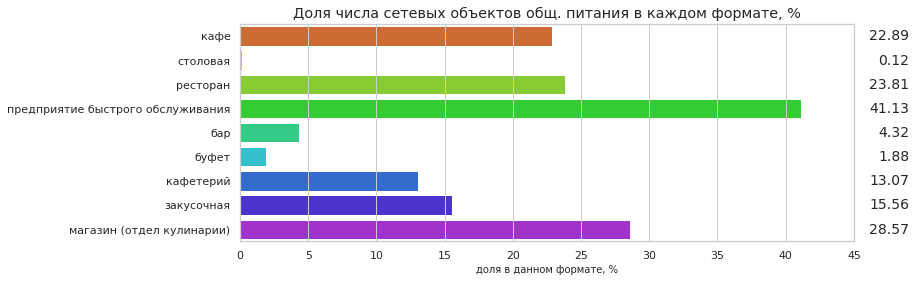

In [21]:
plt.figure(figsize=(11, 4))
sns.barplot(data=data_type, y='object_type', x='chain_share', orient='h', palette='gist_rainbow', saturation =.6, zorder=0)
plt.title('Доля числа сетевых объектов общ. питания в каждом формате, %', fontdict={'fontsize': 'large'})
plt.xlabel('доля в данном формате, %', fontdict={'fontsize': 'small'})
plt.ylabel('');
plt.xlim(0, 45);
the_table = plt.table(cellText=data_type[['chain_share']].values, 
                      bbox=(1, 0, 0.1, 1), edges='open')
the_table.auto_set_font_size(False)
the_table.set_fontsize(14);

**Вывод:** Наиболее популярный формат сетевых компания - "фаст-фуд" 41%, рестораны и кафе 23-24%, специфический вид "отдел кулинарии" занимает 28%, однако его нелязя в полном смысле считать объектом общепита. Наименьшая доля рынка это бары и буфеты 2-4%. 
***
В дальнейшем исследовании основное внимание будем уделять самым популярным форматам сетевых заведений: **"фаст-фуд", кафе и рестораны.**

<a id="24"></a>
**2.4. Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?**[▲](#Содержание)    

Предполагаем, что формат заведения (кафе, столовая и т.д.) будет влиять на число посадочных мест. Поэтому оценим присутствие сетевых компаний одновременно в разных видах общепита.

In [22]:
# сетевые бренды которые имеют точки продаж в разных форматах (ТОП-5)
(df_catering[df_catering['chain']=='да']
              .groupby(['object_name', 'object_type'])
              .agg({'number':'count'}).reset_index().sort_values(by=['number', 'object_name'], ascending=False)
              ['object_name'].value_counts()).head()

Милти          6
Теремок        5
Бургер Кинг    5
Суши Wok       5
ТЕРЕМОК        5
Name: object_name, dtype: int64

Рекордсмен сеть "Милти" - сразу 6 форматов, много сетей с 5 форматами. 
***
Для исключения ошибок делаем двойную группировку данных, по имени сети и по формату. Это уменьшит размер некоторых сетей на субкатегориальных графиках, но позволит корректно отразить долю сети именно в данном формате. 

In [23]:
chain_size = (df_catering[df_catering['chain']=='да'].groupby(['object_name', 'object_type'])
              .agg({'number':['count', 'sum', 'mean']}).reset_index())
chain_size.columns = ['object_name', 'object_type', 'chain_size', 'chain_power', 'chain_mean_number']

In [24]:
# В нашей таблице присутствуют сети у которых открыта только одна торговая точка
# определим нижние границы для отбора сетевых компаний по их размеру 
chain_size['chain_size'].value_counts(normalize=True).head(3)*100

1    59.70
2    12.86
3     6.55
Name: chain_size, dtype: float64

Доля компаний с одной точкой продаж в Москве составляет почти 60%, доля значительна, эти данные исключать нельзя. Исходим из того, что несмотря на наличие всего одной точки в Москве, сетевой статус предполагает наличие определенных стандартов характерных для сетевой компании и это не характеризует распространенность компании в целом по стране или в мире, где число филиалов может быть большим.

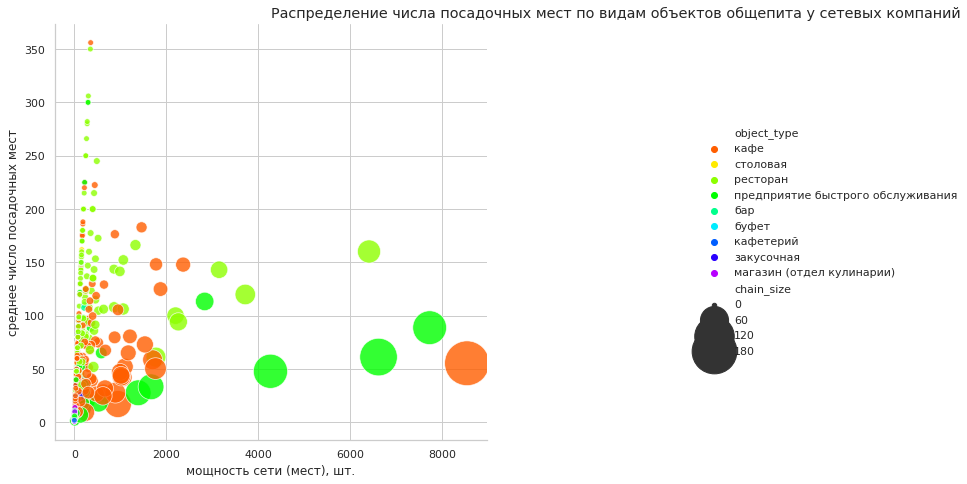

In [25]:
# строим график зависимости среднего числа мест от размера сети и формата заведения
g = sns.relplot(x="chain_power", y="chain_mean_number", size="chain_size", hue='object_type',
            sizes=(20, 2000), alpha=.8, palette='gist_rainbow', legend='brief', 
            data=chain_size, hue_order=object_type_order);

plt.title('Распределение числа посадочных мест по видам объектов общепита у сетевых компаний',
          fontdict={'fontsize': 'large', 'horizontalalignment':'left'});
plt.rc('ytick', labelsize='large');
plt.xlabel('мощность сети (мест), шт.', fontdict={'fontsize': 'medium'})
plt.ylabel('среднее число посадочных мест', fontdict={'fontsize': 'medium'});
g.fig.set_size_inches(15, 7)

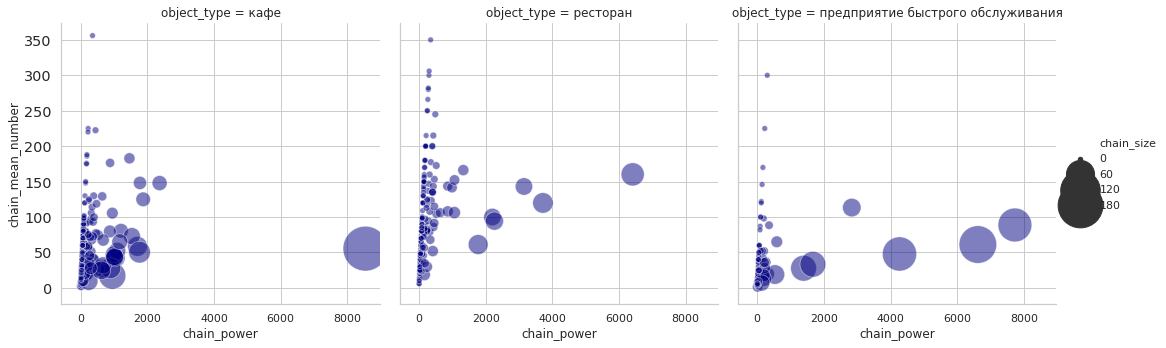

In [26]:
# для наиболее популярных форматов (фаст-фуд, кафе, ресторан)
# строим отдельные графики, для детального анализа
sns.relplot(x="chain_power", y="chain_mean_number", col='object_type', size="chain_size",
            sizes=(20, 2000), alpha=.5, color='navy', col_wrap=3, legend='brief',
            col_order=['кафе', 'ресторан', 'предприятие быстрого обслуживания'], 
            data=chain_size);
plt.rc('ytick', labelsize='large');

**Вывод:** Поведение крупных сетевых компаний, с большим числом точек продаж, заметно отличается в разных форматах и от мелких сетевиков.
Тенденции: 
- кафе - много точек продаж с небольшим количеством мест (около 50); 
- рестораны - самый большой разброс по числу посадочных мест, крупные сети придерживаются среднего размера (50-150 мест); 
- предприятия быстрого обслуживания -  наиболее яркое отличие от других форматов, малые компании имеют точки продаж с малым числом мест, большие - с большим. 

<a id="25"></a>
#### 2.5. Среднее количество посадочных мест для каждого вида объекта общественного питания.  [▲](#Содержание)    

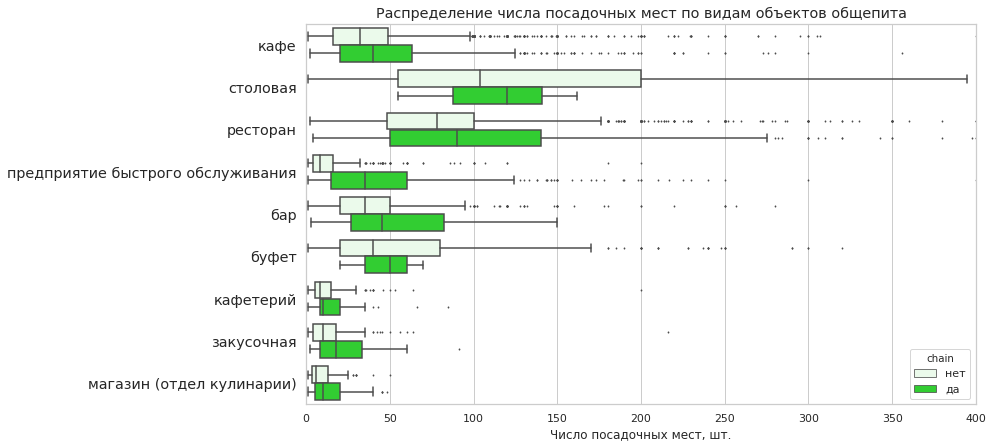

In [27]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_catering, y='object_type', x='number', hue='chain', orient='h',  
              color="limegreen", dodge=1, saturation = 1, fliersize = 1,
             order=object_type_order)
plt.title('Распределение числа посадочных мест по видам объектов общепита', fontdict={'fontsize': 'large'})
plt.xlabel('Число посадочных мест, шт.', fontdict={'fontsize': 'medium'});
plt.ylabel('')
plt.rc('ytick', labelsize='medium');
plt.xlim(0, 400);

In [28]:
# таблица с основными характеристиками по видам общепита
type_number = (df_catering.groupby('object_type')
              .agg({'number':['sum', 'median'], 'id':'nunique'}).reset_index())
type_number = type_number.merge(df_catering[df_catering['chain']=='да']
              .groupby('object_type').agg({'number':['sum', 'median'], 'id':'nunique'}).reset_index(), on='object_type')
type_number.columns = ['object_type', 'type_number', 'type_number_median', 'type_quantity', 
                       'chain_number', 'chain_number_median', 'chain_quantity']
type_number.sort_values(by='type_number', ascending=False)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,object_type,type_number,type_number_median,type_quantity,chain_number,chain_number_median,chain_quantity
8,столовая,336948.00,104.50,2587,337.00,120.00,3
3,кафе,242228.00,35.00,6099,66208.00,40.00,1396
7,ресторан,221266.00,80.00,2285,54527.00,90.00,544
6,предприятие быстрого обслуживания,39522.00,20.00,1923,31772.00,35.00,791
0,бар,37231.00,35.00,856,1962.00,45.00,37
1,буфет,29911.00,40.00,585,140.00,50.00,11
4,кафетерий,3631.00,9.00,398,638.00,10.00,52
2,закусочная,2739.00,10.00,360,805.00,18.00,56
5,магазин (отдел кулинарии),1526.00,8.50,273,677.00,10.00,78


**Вывод:** Самое большое число посадочных мест у столовых, затем идут рестораны и остальные виды заведений общепита. Закономерность едина как для сетевых, так и для самостоятельных компаний. У сетевых компаний среднее число посадочных мест больше чем в среднем по рынку для всех категорий.

<a id="26"></a>
#### 2.6. График топ-10 улиц по количеству объектов общественного питания. Популярные районы Москвы. [▲](#Содержание)    

In [29]:
# выделяем улицу из полного адреса в новый стобец 'street'
df_catering['street'] = df_catering.apply(lambda x: x['address'].split(',')[1], axis=1)

In [30]:
# выделяем ТОП-10 улиц по количеству точек общепита
street_top10 = df_catering['street'].value_counts().head(10).reset_index()
street_top10.columns = ['street', 'cater_count']

In [31]:
# функция определения названия района по заданному адресу через API Яндекс.Карты
def district(address):
    # получаем название района по заданному адресу
    # можно переделать на получение координат геопозиции
    apikey='&apikey=' + 'f25f3b18-6e2a-474a-be62-1ed4c79ee0b5' # API ключ Яндекс.Карт
# Прямое геокодирование 
    BASE_URL = 'https://geocode-maps.yandex.ru/1.x/?format=json'
    QUERY_DIRECT = BASE_URL + apikey + '&geocode=' + address
    
    response = requests.get(QUERY_DIRECT) # запрос
    response_parsed = json.loads(response.text)# сохраняем ответ
    
# определяем координаты по адресу 
    point = response_parsed['response']['GeoObjectCollection']['featureMember'][0]\
    ['GeoObject']['Point']['pos'] 

# Обратное геокодирование / получение компонент адреса по координатам
    QUERY_REVERS = BASE_URL + apikey + '&geocode=' + point.replace(' ',',') 

    response = requests.get(QUERY_REVERS)
    response_parsed = json.loads(response.text)

# Получение названия района
    district1 = response_parsed['response']['GeoObjectCollection']['featureMember'][2]\
         ['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components'][-1]['name']

    district2 = response_parsed['response']['GeoObjectCollection']['featureMember'][1]\
         ['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components'][-1]['name']
# в зависимости от точности адреса может определяться как район так и округ
# поэтому на вывод подается два регистра по глубине, нужный выбирается эмпирически
    return(district1, district2)    

In [32]:
# находим название района по адресу через API Яндекс.Карт для TOP-10
street_top10['district'] = street_top10.apply(lambda x: district('город Москва,'+ x['street']), axis=1)

In [33]:
# Код обработки названий района ниже возможно избыточен, для тренировки.
#
# из данных Яндекс забирается два значения, поскольку слово 'район' встречается на разной 'глубине'.
# часть данных содержит название района, а часть название округа или микрорайона
# 
# обработка выделяет то поле, где есть слово 'район', затем итоги объединяются
street_top10['new1'] = street_top10.loc[street_top10['district'].str[0].str.contains(r'\bрайон\b')].district.str[0]
street_top10['new2'] = street_top10.loc[street_top10['district'].str[1].str.contains(r'\bрайон\b')].district.str[1]
# для записей где не встречается слово 'район' берется первое доступное значение
street_top10['new12'] = street_top10.loc[~(street_top10['district'].str[0].str.contains(r'\bрайон\b'))&\
                                        ~(street_top10['district'].str[1].str.contains(r'\bрайон\b'))].district.str[0]
# складываем все обратно в единый столбец данных
street_top10['district_new'] = street_top10['new1'].fillna(street_top10['new2']).fillna(street_top10['new12'])
# удаляем промежуточные итоги
street_top10.drop(['new1', 'new2', 'new12'], axis=1, inplace=True);

In [37]:
# проверка результата:
#street_top10.style.set_properties(subset='district', **{'text-align':'left', 'text-width':'300px'})

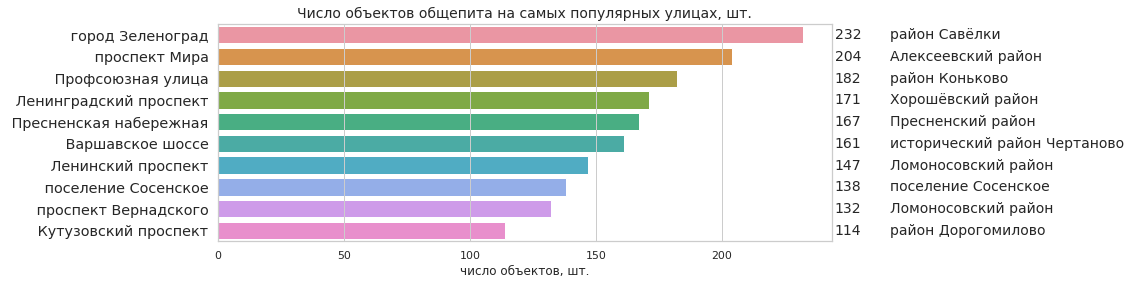

In [38]:
plt.figure(figsize=(11, 4))
sns.barplot(data=street_top10, y='street', x='cater_count', orient='h', zorder=0)
plt.title('Число объектов общепита на самых популярных улицах, шт.', fontsize=14)
plt.xlabel('число объектов, шт.', fontsize=12)
plt.ylabel('', fontsize=12);
plt.rc('ytick', labelsize='large') 
the_table = plt.table(cellText=street_top10[['cater_count', 'district_new']].values, 
                      colWidths=(0.1, 0.9), cellLoc='left', bbox=(1, 0, 0.5, 1), edges='open')
the_table.auto_set_font_size(False)
the_table.set_fontsize(14);

**Вывод:** Наибольшая плотность точек общепита в Зеленограде, возможно это связано с тем, что это "наукоград" с преимущественно молодым и активным населением. Для остальных районов могут влиять близость от туристических объектов, деловых и торговых центров,  ВУЗов.    

<a id="27"></a>
#### 2.7. Найдите число улиц с одним объектом общественного питания. В каких районах Москвы находятся эти улицы?[▲](#Содержание)    

In [39]:
# формируем список улиц с одним объектом общепита
street_loneliness = df_catering.groupby('street')['id'].nunique().reset_index()
street_loneliness = street_loneliness[street_loneliness['id'] == 1]
street_loneliness = street_loneliness['street'].values
print('Число районов с одним объектом общепита:', street_loneliness.shape[0], 'шт.')

Число районов с одним объектом общепита: 579 шт.


In [40]:
# находим название района по адресу через API Яндекс.
# вывод сделан для первых 7 районов
df_catering_loneless = df_catering[df_catering['street'].isin(street_loneliness)].head(7) # здесь можно снять ограничение
df_catering_loneless['district'] = df_catering_loneless.apply(lambda x: district(x['address'])[0], axis=1) 
df_catering_loneless

,id,object_name,chain,object_type,address,number,street,district
19,153644,Американская Лаборатория Десертов,нет,кафе,"город Москва, Филипповский переулок, дом 15/5",20.00,Филипповский переулок,180-й квартал
61,21214,Столовая,нет,столовая,"город Москва, Бабаевская улица, дом 3",90.00,Бабаевская улица,район Сокольники
69,22139,ХуанХэ,нет,ресторан,"город Москва, 1-й Балтийский переулок, дом 3/25",60.00,1-й Балтийский переулок,район Аэропорт
81,25833,АЗЕРБАЙДЖАН,нет,ресторан,"город Москва, улица Демьяна Бедного, дом 4",180.00,улица Демьяна Бедного,район Хорошёво-Мнёвники
131,150881,ВГИК,нет,столовая,"город Москва, Будайская улица, дом 3",45.00,Будайская улица,район Ростокино
150,24155,Советские времена,да,кафе,"город Москва, Варсонофьевский переулок, дом 6",82.00,Варсонофьевский переулок,Мещанский район
179,24646,Угол,нет,кафе,"город Москва, Верхняя улица, дом 3, корпус 2",71.00,Верхняя улица,район Беговой


**Вывод:** В Москве находится **579 улиц с одной точкой общепита**. В таблице сделан вывод первых 7 записей из списка с указанием района Москвы. Для получения данных использован API Яндекс.Карт. При необходимости можно получить данные по всем записям.

<a id="28"></a>
#### 2.8. Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. [▲](#Содержание)    

In [41]:
# добавляем колонку 'top' с признаком вхождения в ТОП-10 улиц с наибольшей плотностью точек общепита
# полученный признак будем использовать при построении графика
df_catering['top'] = df_catering['street'].isin(street_top10['street'].values)

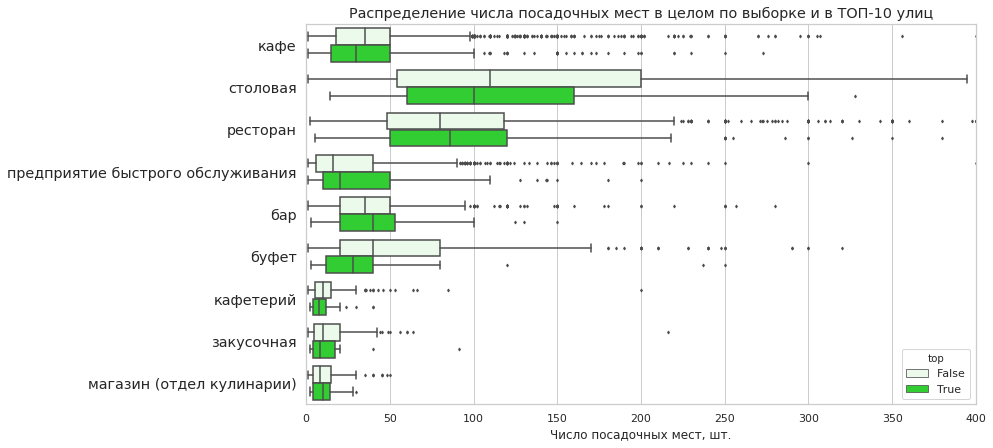

In [42]:
# график распределения числа посадочных мест в целом по выборке и в ТОП-10 улиц
plt.figure(figsize=(12, 7))
ax = sns.boxplot(data=df_catering, y='object_type', x='number', hue='top', orient='h',  
              color="limegreen", dodge=1, saturation = 1, fliersize = 2,
             order=object_type_order)
plt.title('Распределение числа посадочных мест в целом по выборке и в ТОП-10 улиц', fontdict={'fontsize': 'large'})
plt.xlabel('Число посадочных мест, шт.', fontdict={'fontsize': 'medium'});
plt.ylabel('')
plt.rc('ytick', labelsize='medium');
plt.xlim(0, 400);


**Вывод:** в популярных местах среднее число посадочных мест в **ресторанах, барах и фаст-фуде** больше чем в целом по выборке, для остальных форматов наоборот - меньше.

<a id="summary"></a>
## Общий вывод.[▲](#Содержание)    

Позиционирование можно свести к одному вопросу: **"робот обходится дешевле человека или нет?"** \
На данный момент роботы - хороший рекламный ход, поэтому стоит размещаться в зонах с высокой проходимостью, т.е. выбирать районы с большой плотностью точек общепита.

**Если "нет".** 
- "Бутиковое" направление: **кафе, рестораны, бары.** Роботы - только элемент рекламы для привлечения клиентов, успех зависит от остальных компонент заведения. оптимальный размер для кафе - 40 мест. 

**Если "да".** 
- **Фаст-фуд.** Максимальный эффект от автоматизации достигается в массовом сегменте и скорее всего массово роботы появятся именно тут. Размещать стоит в зонах скопления туристов и молодежи. Подобная точка питания станет самостоятельной достопримечательностью и будет иметь гарантированный поток "одноразовых" клиентов. Наличе роботов должно повысит скорость обслуживания клиентов, что важно как раз в этом сегменте. Стандартное меню без "изысков", хорошо сочетается с автоматизацией. Размер 50-100 мест, на уровне крупных сетевиков. С масштабированием также все проще.


**PS**
\
Из описания проекта следует, что его основной чертой будет эпатажная форма подачи блюд (роботы), а не их гастрономическая ценность. Для правильного позиционирования проекта нужны еще ответы на вопросы:
- использование роботов дает прирост производительности труда или только антураж?
- какую функцию обслуживания будут выполнять роботы: прием заказа, доставка заказа к столу  и т.п.?
- портрет клиента и какие качества объекта общепита для этой целевой группы клиентов будут востребованы.
- экономические показатели (стоимость обслуживания по сравнению с работой выполненной человеком)

Общепит выполняет две функции: "пообщаться" и "поесть". Можно сказать и так: если формат заведения предполагает звучание музыки, особенно "живой", то это заведение прежде всего нацелено на общение людей, в том числе с официантами, и роботы тут будут вряд ли уместны.\

Прогресс в любой области это снижение издержек и использование все большей автоматизации (роботов) неизбежно. Еще во времена СССР создавались "комбинаты питания", где на высокопроизводительном оборудование готовилась пища, которая затем развозилась по садам, школам и другим учреждениям. Это разделение точки приготовления и точки потребления фактически повторяется современным фаст-фудом. Принципиальное отличие схемы только в приготовлении полуфабриката, который может храниться значительно дольше и территория его распределения соответственно больше. На этом этапе автоматизирован процесс приготовления пищи, следующий этап это как раз автоматизация обслуживания клиентов, т.е. роботы.\


\
По мере снижения стоимости технологии, в том или ином виде роботы будут переходить из сегмента фаст-фуда во все остальные, вплоть до  наименее маржинальных.

<a id="presentation"></a>
## Презентация
https://yadi.sk/i/nf1_x6DZRSwcbQ